<a href="https://colab.research.google.com/github/benduong2001/dsproject_font_decorator_bolditalic_unet/blob/main/font_bolditalic_unet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = (7,7)

In [2]:
from tqdm import tqdm

In [3]:
# example of training an conditional gan on the mnist dataset
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt
#import seaborn as sns
#plt.style.use("ggplot")
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [4]:
import pickle


In [5]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
PATH_FOLDER = "/content/drive/MyDrive/dsprojects/dsproject_imagery/dsprojects_fonts/"

In [7]:
f = open(PATH_FOLDER+'unet_font_x_train_v2.pkl', 'rb') 
x_train = pickle.load(f)
f.close()     
f = open(PATH_FOLDER+'unet_font_y_train_v2.pkl', 'rb') 
y_train = pickle.load(f)
f.close()   
f = open(PATH_FOLDER+'unet_font_x_test_v2.pkl', 'rb') 
x_test = pickle.load(f)
f.close()   
f = open(PATH_FOLDER+'unet_font_y_test_v2.pkl', 'rb') 
y_test = pickle.load(f)
f.close()   

In [8]:
len(x_train), len(y_train),len(x_test),len(y_test)

(45572, 45572, 15164, 15164)

In [9]:
x_train[0].shape, y_train[0].shape, x_test[0].shape, y_test[0].shape, 

((20, 40, 1), (20, 40, 1), (20, 40, 1), (20, 40, 1))

In [10]:
x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
x_test = np.array(x_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [11]:
np.random.seed(1)
randomize = np.arange(len(x_train))
np.random.shuffle(randomize)
x_train_ = x_train[randomize]
y_train_ = y_train[randomize]

In [12]:
def Conv_Dim_Preserved(x, n_filters):
    # preserve dimensiond: keep padding same, no stride
    # 1st round of conv
    x = Conv2D(filters = n_filters, 
               kernel_size = (3, 3),
               kernel_initializer = 'he_normal', 
               padding = 'same')(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)
    # 2nd round of conv
    x = Conv2D(filters = n_filters, 
               kernel_size = (3, 3),
               kernel_initializer = 'he_normal', 
               padding = 'same')(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    return x

N_FILTERS = 32

inputs = Input((20, 40, 1))
x = inputs

# 20 by 20

c1 = Conv_Dim_Preserved(x, N_FILTERS*1)
print(c1.shape)
p1 = MaxPooling2D((2, 2), padding="same")(c1) # reduce dimensionality

# 10 by 10

c2 = Conv_Dim_Preserved(p1, N_FILTERS*2)
print(c2.shape)
p2 = MaxPooling2D((2, 2), padding="same")(c2) # reduce dimensionality

# 5 by 5

# Bottom of the unet "valley"
c3 = Conv_Dim_Preserved(p2, N_FILTERS*4)
# climb back up

u4 = Conv2DTranspose(N_FILTERS*2, (3, 3), strides = (2, 2), padding = 'same')(c3)
print(u4.shape, c2.shape)
u4 = Concatenate()([u4, c2])
#u4 = Dropout(0.1)(u4)
c4 = Conv_Dim_Preserved(u4, N_FILTERS*2)
# 10 x 10

u5 = Conv2DTranspose(N_FILTERS*1, (3, 3), strides = (2, 2), padding = 'same')(u4)
print(u5.shape, c1.shape)
u5 = Concatenate()([u5, c1])
#u5 = Dropout(0.1)(u5)
c5 = Conv_Dim_Preserved(u5, N_FILTERS*1)
# 10 x 10

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5) # CHANNEL IS 1
unet_model = Model(inputs=[inputs], outputs=[outputs])

unet_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

unet_model.summary()

(None, 20, 40, 32)
(None, 10, 20, 64)
(None, 10, 20, 64) (None, 10, 20, 64)
(None, 20, 40, 32) (None, 20, 40, 32)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 40, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 20, 40, 32)   320         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 20, 40, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 40, 32)  128         ['activation[0

In [13]:
history = unet_model.fit(x_train_, y_train_,epochs=5, batch_size=20)

Epoch 1/5
2279/2279 [==============================] - 643s 281ms/step - loss: 0.1293 - accuracy: 0.6124
Epoch 2/5
2279/2279 [==============================] - 622s 273ms/step - loss: 0.1091 - accuracy: 0.6151
Epoch 3/5
 640/2279 [=======>......................] - ETA: 7:24 - loss: 0.1038 - accuracy: 0.6155

KeyboardInterrupt: ignored

In [14]:
output_data = unet_model.predict(x_test, batch_size=512)

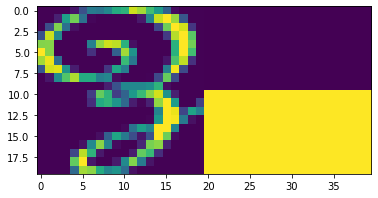

In [110]:
test_idx = 900 # Q, italic
test_idx = 902 # Q, bolded
test_idx = 67 # san-serif P, italic
test_idx = 261 # serif M, italic
test_idx = 262 # serif M, bolded
test_idx = 1400 # scribbly K, italic
test_idx = 2000 # script O, bolded
test_idx = 1800 # broadaway N, italic
test_idx = 6000 # Gothic O, bold
test_idx = 5998 # Gothic O, italic
test_idx = 3443 # slab serif F, bold
test_idx = 5437 # cursive z?, italic
test_idx = 5438 # cursive z?, bold


plt.imshow(np.squeeze((x_test[test_idx]*255).astype(int)))

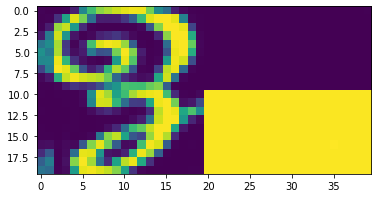

In [111]:
plt.imshow(np.squeeze((output_data[test_idx]*255).astype(int)))

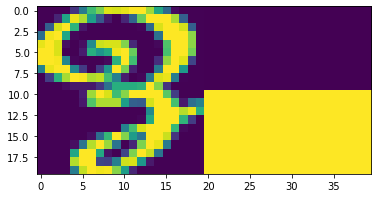

In [112]:
plt.imshow(np.squeeze((y_test[test_idx]*255).astype(int)))

In [113]:
unet_model.save(PATH_FOLDER + "model_font_bolditalic_v2.h5")

**User's Input**
* Include the input image png path. It must be a 20x20 picture with white text on a black background
* Include the character styling: bold, italic, both, neither

In [140]:
INPUT_IMAGE_FILE_NAME = "input_image.png" # must be white text on black background
BOLD_OPTION = True
ITALIC_OPTION = True

In [141]:
from PIL import Image

def temp_create_channels(channel_type):
    # channel_type is 1 for italic, 2 for bold, 3 for both
    DIM1 = 20
    DIM2 = 20
    if channel_type == 0:
        return np.zeros((DIM1,DIM2))
    elif channel_type == 3:
        return temp_create_channels(1) + temp_create_channels(2)
    else:
        channel = np.zeros((DIM1,DIM2))
        ohe_divisions = 2
        span = DIM1//ohe_divisions

        span_idx = channel_type-1
        start = (span_idx*span)
        stop = (start+span)
        channel[(start):(stop),:] = 1
        return channel

saved_unet_model = tf.keras.models.load_model(PATH_FOLDER + "model_font_bolditalic_v2.h5")

In [142]:
PATH_INPUT_IMAGE = PATH_FOLDER + INPUT_IMAGE_FILE_NAME
input_image = Image.open(PATH_INPUT_IMAGE)

# Image pre-processing

input_image_arr = np.array(input_image)
input_image_arr = input_image_arr.astype(float)
#MAX_PIXEL_SHADE = 255
MAX_PIXEL_SHADE = input_image_arr.max()
input_image_arr /= MAX_PIXEL_SHADE

In [143]:
# One hot encoding onto the input image
if (BOLD_OPTION==True):
    if (ITALIC_OPTION==True):
        channel_type = 3
    else:
        channel_type = 2
else:
    if (ITALIC_OPTION==True):
        channel_type = 1
    else:
        channel_type = 0

temp_channel = temp_create_channels(channel_type).astype(float)
input_image_arr_concat = np.hstack([input_image_arr,temp_channel])
# plt.imshow((input_image_arr_concat*255).astype(int))

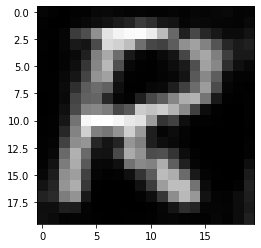

In [144]:
model_input_image = np.array([np.expand_dims(input_image_arr_concat,2)])
# model_input_image.shape # x_test.shape
output_generation = unet_model.predict(model_input_image)

output_generation_image_array = np.squeeze((output_generation[0]*255).astype(int))

output_generation_image = output_generation_image_array[:, :20]
plt.imshow(output_generation_image, cmap="gray")

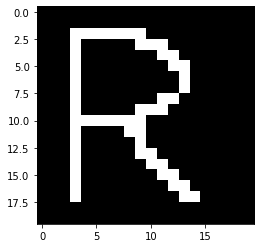

In [145]:
# compared to the original image
plt.imshow(input_image, cmap="gray")